### importar librerías

In [ ]:
import os
import random
from calendar import EPOCH

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from alembic.command import history
from keras.src.metrics.metrics_utils import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.saving.saved_model.load import training_lib

IMAGES_DIR = "../data/papila-db/FundusImages/"

### obtener datos

In [ ]:
import openpyxl
df_od = pd.read_excel("../data/papila-db/ClinicalData/patient_data_od.xlsx", header=1, skiprows=[2])
df_os = pd.read_excel("../data/papila-db/ClinicalData/patient_data_os.xlsx", header=1, skiprows=[2])

In [39]:
df_od

,Unnamed: 0,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD
0,#002,47,0,2,0.75,-1.75,90.0,0.0,21.0,NaN,586.0,23.64,-0.07
1,#004,58,1,1,1.50,-1.75,85.0,0.0,NaN,19.0,501.0,23.06,-3.26
2,#005,89,1,1,-0.75,-1.25,101.0,1.0,13.0,14.0,565.0,23.81,-14.98
3,#006,69,0,2,1.00,-1.50,95.0,0.0,22.0,NaN,612.0,26.25,-2.07
4,#007,22,1,2,-0.25,0.00,0.0,0.0,14.0,NaN,NaN,23.39,-2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,#289,64,0,0,0.50,-1.00,120.0,1.0,12.0,NaN,529.0,22.27,NaN
240,#290,75,1,0,0.25,-0.25,5.0,1.0,14.0,NaN,577.0,22.00,NaN
241,#291,55,0,0,1.25,-1.25,92.0,0.0,12.0,NaN,452.0,23.53,NaN
242,#292,56,1,0,1.75,-1.50,73.0,0.0,10.0,NaN,499.0,23.68,NaN


In [40]:
df_os

,Unnamed: 0,Age,Gender,Diagnosis,dioptre_1,dioptre_2,astigmatism,Phakic/Pseudophakic,Pneumatic,Perkins,Pachymetry,Axial_Length,VF_MD
0,#002,47,0,2,-0.50,-1.50,88.0,0.0,20.0,NaN,603.0,23.77,0.17
1,#004,58,1,1,1.50,-2.50,85.0,1.0,NaN,19.0,511.0,22.96,-6.77
2,#005,89,1,1,-0.50,-2.00,100.0,1.0,24.0,10.0,575.0,24.33,-7.44
3,#006,69,0,2,1.00,-1.50,85.0,0.0,22.0,NaN,593.0,26.21,-3.31
4,#007,22,1,2,-0.25,-0.50,0.0,0.0,13.0,NaN,NaN,23.35,-2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,#289,64,0,0,0.75,-1.50,93.0,1.0,10.0,NaN,531.0,22.31,NaN
240,#290,75,1,0,0.25,-0.25,160.0,1.0,19.0,NaN,573.0,22.01,NaN
241,#291,55,0,0,1.50,-1.25,76.0,0.0,14.0,NaN,443.0,23.51,NaN
242,#292,56,1,0,1.25,-0.75,79.0,0.0,9.0,NaN,479.0,23.84,NaN


In [41]:
X_od = "RET" + df_od["Unnamed: 0"].astype(str).str[1:] + "OD.jpg"
y_od = df_od["Diagnosis"]

X_od, y_od

(0      RET002OD.jpg
 1      RET004OD.jpg
 2      RET005OD.jpg
 3      RET006OD.jpg
 4      RET007OD.jpg
            ...     
 239    RET289OD.jpg
 240    RET290OD.jpg
 241    RET291OD.jpg
 242    RET292OD.jpg
 243    RET293OD.jpg
 Name: Unnamed: 0, Length: 244, dtype: object,
 0      2
 1      1
 2      1
 3      2
 4      2
       ..
 239    0
 240    0
 241    0
 242    0
 243    0
 Name: Diagnosis, Length: 244, dtype: int64)

### cargar imagenes

In [42]:
import cv2

def load_image(file_name):
    try:
        # Construye la ruta de forma segura
        image_path = os.path.join(IMAGES_DIR, file_name)

        img = cv2.imread(image_path)

        # Verifica si la imagen se cargó correctamente ANTES de procesarla
        if img is None:
            print(f"Alerta: No se pudo cargar la imagen. Archivo no encontrado en: {image_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (644, 484))
        return img
    except Exception as e:
        # Usa un f-string para imprimir el error correctamente
        print(f"Error procesando la imagen '{file_name}': {e}")
        return None

In [43]:
# Código Corregido
# 1. Cargamos las imágenes en una lista temporal
images_list = [load_image(file_name) for file_name in X_od]

# 2. Filtramos los valores 'None' que resultaron de errores de carga
X_od_filtered = [img for img in images_list if img is not None]

# 3. Solo ahora creamos el array de NumPy con la lista limpia
X_od = np.array(X_od_filtered)
y_od = df_od["Diagnosis"].values

In [44]:
print(f"Dimensión de imágenes: {X_od.shape}")
print(f"Total categorías: {len(np.unique(y_od))}")

Dimensión de imágenes: (244, 484, 644, 3)
Total categorías: 3


### dividir en train y test

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_od, y_od, test_size=0.1, random_state=42)

In [46]:
print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 219
Tamaño del conjunto de prueba: 25


### Normalizar y Cargado en Bloque

In [47]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

def prepare_subset(images, labels, batch_size):
    subset = tf.data.Dataset.from_tensor_slices((images, labels))
    batches = subset.cache()
    batches = batches.shuffle(len(images) // 4)
    batches = batches.batch(batch_size).map(normalize).prefetch(1)
    return batches

In [48]:
BATCH_SIZE = 25

training_batches = prepare_subset(X_train, y_train, BATCH_SIZE)
testing_batches = prepare_subset(X_test, y_test, BATCH_SIZE)

for image_batch, label_batch in training_batches.take(1):
    print('Image batch shape: ', image_batch.shape)
    print('dtype: ', image_batch.dtype)
    print('Etiquetas:', label_batch)

Image batch shape:  (25, 484, 644, 3)
dtype:  <dtype: 'float32'>
Etiquetas: tf.Tensor([1 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 1], shape=(25,), dtype=int64)


### Modelación

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

tf.keras.backend.clear_session()

'''
model = tf.keras.models.Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(484, 644, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
'''

model = tf.keras.models.Sequential([
    Flatten(input_shape=(484, 644, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])


c:\Users\darwi\anaconda3\envs\m13_proyecto_glaucoma\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [50]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 935088)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   119,691,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,699,843 (456.62 MB)

 Trainable params: 119,699,843 (456.62 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy_score = model.evaluate(image_batch, label_batch)

print('Loss (antes del entrenamiento): ', format(loss, '.3f'))
print('Accuracy (antes del entrenamiento): ', format(accuracy_score, '.3f'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 0.5600 - loss: 1.0065
Loss (antes del entrenamiento):  1.006
Accuracy (antes del entrenamiento):  0.560


In [52]:
EPOCH = 10

history = model.fit(training_batches, epochs=EPOCH)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5616 - loss: 111.8591
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5205 - loss: 80.8045
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5662 - loss: 32.2183
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5160 - loss: 17.1491
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6301 - loss: 18.4717
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5068 - loss: 16.9506
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5388 - loss: 10.7153
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5434 - loss: 23.2391
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5297 - loss: 14.7034
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.6530 - loss: 18.9485


In [53]:
print(history.params)
print(history.history['loss'])
print(history.history['accuracy'])

{'verbose': 'auto', 'epochs': 10, 'steps': 9}
[111.85906219482422, 80.8045425415039, 32.21828079223633, 17.14906120300293, 18.471668243408203, 16.950584411621094, 10.715335845947266, 23.239107131958008, 14.703437805175781, 18.948488235473633]
[0.5616438388824463, 0.5205479264259338, 0.5662100315093994, 0.5159817337989807, 0.6301369667053223, 0.5068492889404297, 0.5388127565383911, 0.543379008769989, 0.5296803712844849, 0.6529680490493774]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
index:  16
label:  tf.Tensor([0 0 2 1 0 0 0 0 0 2 0 0 0 0 2 2 1 0 0 0 1 1 0 0 0], shape=(25,), dtype=int64)
probabilidades:  [1.2234482e-04 5.7101242e-30 9.9987769e-01]
valor predicho:  2
valor verdadero:  tf.Tensor(1, shape=(), dtype=int64)


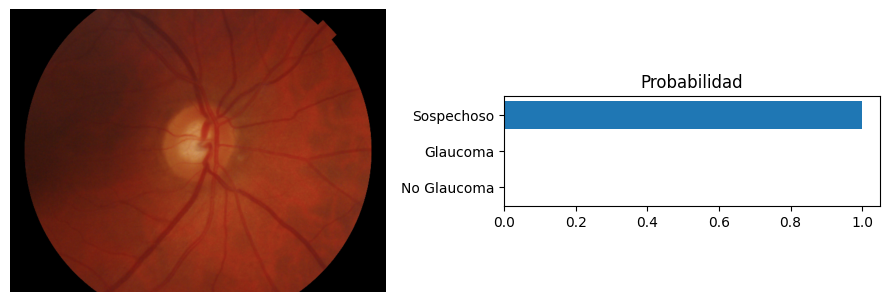

In [54]:
import random

index = 0

for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    index = random.randint(0, len(label_batch)-1)
    print("index: ", index)
    print("label: ", label_batch)
    first_image = image_batch.numpy().squeeze()[index]
    print("probabilidades: ", ps[index])
    print("valor predicho: ", np.argmax(ps[index]))
    print("valor verdadero: ", label_batch[index])

fig, (ax1, ax2) = plt.subplots(figsize=(9, 12), ncols=2)
ax1.imshow(first_image)
ax1.axis('off')
ax2.barh(np.arange(3), ps[index])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(["No Glaucoma", "Glaucoma", "Sospechoso"])
ax2.set_title('Probabilidad')
ax2.set_xlim(0, 1.05)
plt.tight_layout()


In [56]:
# %mkdir saved_model
import gc

# Liberar memoria antes de guardar
# gc.collect()
# tf.keras.backend.clear_session()


model.save('saved_model/sequential_glaucoma.keras')